# Infinite Random Walks on Graph Networks

In [51]:
#Import Packages

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import networkx as nx
import torch
import kornia
import scipy.sparse
import os
from scipy.sparse.linalg import spsolve, cg
np.set_printoptions(threshold=np.inf)

## Background

An $\textit{incidence matrix}$ is a logical matrix that shows the relationship between two classes of objects. 

Suppose we have the graph shown below:

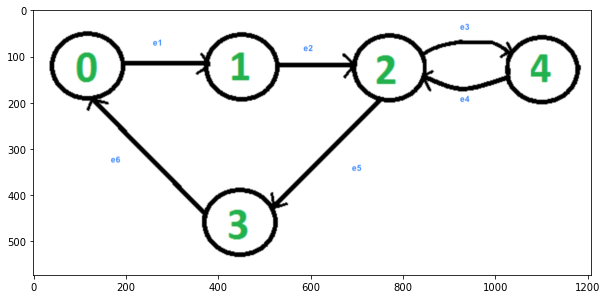

In [42]:
graph = plt.imread('cycle-BFS.png')
plt.figure(figsize = (10,10))
plt.imshow(graph)

The incidence matrix $S$ is a function that maps vertices to edges. The incidence matrix for this example is
$$ S =
\begin{bmatrix}
% 0 1  2 3  4
 -1 & 1 & 0 & 0 & 0 \\ 
 0 & -1 & 1 & 0 & 0 \\
 0 & 0 & -1 & 0 & 1 \\
 0 & 0 & 1 & 0 & -1 \\
 0 & 0 & -1 & 1 & 0 \\
 1 & 0 & 0 & -1 & 0 \\
\end{bmatrix}
$$
where the columns represent vertices and the rows represent edges.

A weight matrix maps edges to edges and can be represented for this graph as
$$
\begin{bmatrix}
w_1 & 0 & 0 & 0 & 0 & 0 \\
0 & w_2 & 0 & 0 & 0 & 0 \\
0 & 0 & w_3 & 0 & 0 & 0 \\
0 & 0 & 0 & w_4 & 0 & 0 \\
0 & 0 & 0 & 0 & w_5 & 0 \\
0 & 0 & 0 & 0 & 0 & w_6 \\
\end{bmatrix}
$$ and if each vertex is represented by a vector, the weight would be
$$
\begin{bmatrix}
[W_1] & 0 & 0 & 0 & 0 & 0 \\
0 & [W_2] & 0 & 0 & 0 & 0 \\
0 & 0 & [W_3] & 0 & 0 & 0 \\
0 & 0 & 0 & [W_4] & 0 & 0 \\
0 & 0 & 0 & 0 & [W_5] & 0 \\
0 & 0 & 0 & 0 & 0 & [W_6] \\
\end{bmatrix}
$$ where each $W_n$ is a square $n\times n$ matrix in which $n$ is the size of the vertex vectors. Consider another example:

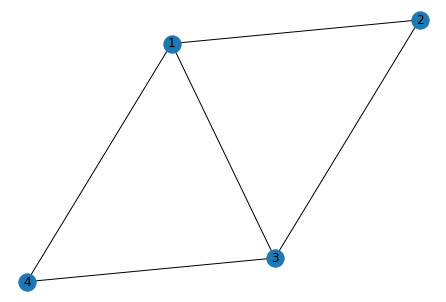

In [50]:
G=nx.Graph()

# adding nodes
# G.add_nodes_from([1,4])
G.add_node('1')
G.add_node('2')
G.add_node('3')
G.add_node('4')

G.add_edge('1','2')
G.add_edge('2','3')
G.add_edge('3','4')
G.add_edge('4','1')
G.add_edge('3','1')

nx.draw(G, with_labels = True)
#plt.show(G)

Probability matrix and a random walk:

$$P = 
\begin{bmatrix}
P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & 0 \\
P_{31} & P_{32} & P_{33} & P_{34} \\
P_{41} & 0 & P_{43} & P_{44} \\
\end{bmatrix}
$$

Adjacency matrix for a random walk:

$$A = 
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 \\
1 & 0 & 1 & 1 \\
\end{bmatrix}
$$

Degree matrix for a random walk:

$$D = 
\begin{bmatrix}
4 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 4 & 0 \\
0 & 0 & 0 & 3 \\
\end{bmatrix}
$$
These degree matrices are one higher than expected since each step includes the possibility of staying at the node.

Pseudo inverse: $P = D^{-1}A$ where $D^{-1}$ is
$$D^{-1} = 
\begin{bmatrix}
1/4 & 0 & 0 & 0 \\
0 & 1/3 & 0 & 0 \\
0 & 0 & 1/4 & 0 \\
0 & 0 & 0 & 1/3 \\
\end{bmatrix}
$$

Furthermore, there exists some $W$ for which $P = W^{-1}A$. 

Since the Network Laplacian is $L = D - A$ we get $$ P = D^{-1}(D - L) = I - D^{-1}L = 1 - L_w $$
where $L_w$ includes information about the weights and adjacency structure of the graph. We can use these probability matrices to model flows through the graph.

$\textbf{Consider what the edge weights look like if the nodes are vectors.}$ In this case, the edge weights go from scalars to square matrices dependent on the size of the node vectors. 

## 2-Class Random Walk

In [11]:
Weight = np.array([[1/4, 1/4, 1/4, 1/4],
                 [1/3, 1/3, 1/3, 0],
                 [1/4, 1/4, 1/4, 1/4],
                 [1/3, 0, 1/3, 1/3]])

In [46]:
def KronTensorDecomp(nodes, dim, regularLap):
    matlist = []
    for i in range(nodes):
        for j in range(nodes):
            zer = np.zeros((nodes,nodes))
            zer[i,j] = 1
            section = np.kron(zer,(regularLap[i,j]*np.identity(dim)))
            matlist.append(section)
    Ak = np.zeros((section.shape))        
    for k in range(nodes*nodes):
        Ak = Ak + matlist[k]
    return  matlist, Ak
    
P = KronTensorDecomp(4, 2, Weight)
P = P[1]
P[2,:]

array([0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
       0.        , 0.        , 0.        ])

In [14]:
truck = np.array([[100,100], [60,0], [0,60], [0,0]]).flatten()
truck.shape
truck @ P 

array([45., 40., 45., 40., 45., 40., 25., 40.])

In [15]:
def RWIter(tensordecomp, start, steps):
    tensordecomp2 = start @ tensordecomp
    for i in range(steps):
        tensordecomp2 = tensordecomp2 @ tensordecomp
    return tensordecomp2

In [18]:
# Converges to equilibrium
RWIter(P, truck, 3000)

array([45.71428571, 45.71428571, 34.28571429, 34.28571429, 45.71428571,
       45.71428571, 34.28571429, 34.28571429])

In [ ]:
# This is the simplest result, we have essentially run two equivalent vector valued random walks...

In [19]:
# Suppose we have two walker classes, one that can stay on a node and one that cannot
Walk1 = np.array([[1/4, 1/4, 1/4, 1/4],
                 [1/3, 1/3, 1/3, 0],
                 [1/4, 1/4, 1/4, 1/4],
                 [1/3, 0, 1/3, 1/3]])
Walk2 = np.array([[0, 1/3, 1/3, 1/3],
                 [1/2, 0, 1/2, 0],
                 [1/3, 1/3, 0, 1/3],
                 [1/2, 0, 1/2, 0]])

In [20]:
pi1 = np.array([[1,0],
                [0,0]])
pi2 = np.array([[0,0],
                [0,1]])

In [30]:
trans1 = np.kron(Walk1,pi1)
trans2 = np.kron(Walk2,pi2)

In [48]:
transition = trans1 + trans2
transition[1,:]

array([0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.33333333, 0.        , 0.33333333])

In [39]:
# Let's see the results with the same starting values
truck2 = np.array([[100,100], [0,60], [0,60], [0,0]]).flatten()
RWIter(transition, truck2, 1000).reshape((4,2))

array([[28.57142857, 66.        ],
       [21.42857143, 44.        ],
       [28.57142857, 66.        ],
       [21.42857143, 44.        ]])

Random walks are still independent, but now there are unique results. Lets add mixing terms which complicates things. Note that all transition matrices created so far are right stochastic (rows sum to 1). Suppose that node 3 allows mixing between classes:

# Exchange Model

Consider we have three digital wallets in a closed network. Within the network there exists 500 dollars and 500 crypto coins. Assets move between accounts 1 and 2 and can be traded or "mixed" on the exchange node. 

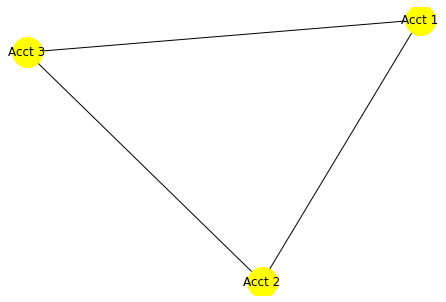

In [22]:
# Suppose we have the closed financial network between three accounts

finLinx=nx.Graph()

finLinx.add_nodes_from(['Acct 1', 'Acct 2', 'Acct 3'])
finLinx.add_edge('Acct 1','Acct 2')
nx.add_star(finLinx, ['Acct 3','Acct 1','Acct 2'])

nx.draw(finLinx, node_size = 900, node_color = 'yellow', with_labels = True)

In [96]:
# Each starts out with this much in a wallet
start1 = np.array([[150, 0],
                    [50, 200 ],
                    [300, 300]])
start1

array([[150,   0],
       [ 50, 200],
       [300, 300]])

In [72]:
# Helpful for building block matrices later
zoz = np.zeros((2,2))
eyeReg = np.eye(2)
eyeInv = np.array([
    [0,1],
    [1,0]
])
eye1 = np.array([
    [1,0],
    [0,0]
])
eye2 = np.array([
    [0,0],
    [0,1]
])

In [73]:
cash = np.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]
])

crypto = np.array([
    [0.5, 0.25, 0.25],
    [0.25, 0.5, 0.25],
    [0.25, 0.25, 0.5]
])

In [102]:
# The transition matrix
transmat1 = np.kron(cash, eye1) + np.kron(crypto, eye2)
transmat1

array([[0.8 , 0.  , 0.1 , 0.  , 0.1 , 0.  ],
       [0.  , 0.5 , 0.  , 0.25, 0.  , 0.25],
       [0.1 , 0.  , 0.8 , 0.  , 0.1 , 0.  ],
       [0.  , 0.25, 0.  , 0.5 , 0.  , 0.25],
       [0.1 , 0.  , 0.1 , 0.  , 0.8 , 0.  ],
       [0.  , 0.25, 0.  , 0.25, 0.  , 0.5 ]])

In [106]:
# Iterate the random walk over a specified number of steps
def RWIter(tensordecomp, start, steps):
    start = start.flatten()
    tensordecomp2 = start @ tensordecomp
    for i in range(steps):
        tensordecomp2 = tensordecomp2 @ tensordecomp
    return tensordecomp2.reshape((3,2))

RWIter(transmat1, start1, 100)

array([[166.66666667, 166.66666667],
       [166.66666667, 166.66666667],
       [166.66666667, 166.66666667]])

In [104]:
# We can adjust the transition matrix to allow for mixing at the nodes. The result is more interesting
transmat2 = np.array(transmat1)

transmat2[0,0] = 0.6
transmat2[0,1] = 0.2

transmat2[3,3] = 0.4
transmat2[3,2] = 0.1

transmat2[4,4] = 0.7
transmat2[4,5] = 0.1

transmat2

array([[0.6 , 0.2 , 0.1 , 0.  , 0.1 , 0.  ],
       [0.  , 0.5 , 0.  , 0.25, 0.  , 0.25],
       [0.1 , 0.  , 0.8 , 0.  , 0.1 , 0.  ],
       [0.  , 0.25, 0.1 , 0.4 , 0.  , 0.25],
       [0.1 , 0.  , 0.1 , 0.  , 0.7 , 0.1 ],
       [0.  , 0.25, 0.  , 0.25, 0.  , 0.5 ]])

In [109]:
RWIter(transmat2, start1, 5000)

array([[ 62.30529595, 246.105919  ],
       [171.33956386, 202.49221184],
       [ 77.88161994, 239.87538941]])

In [130]:
import scipy.linalg as la

vals = la.eig(transmat1)
vals1 = vals[0]
vals2 = vals[1]

array([[-8.16496581e-01,  5.77350269e-01,  2.28557576e-17,
         1.96902621e-01,  1.61192499e-17,  2.59874751e-18],
       [ 0.00000000e+00,  0.00000000e+00, -8.16496581e-01,
         5.42736300e-01, -4.11193713e-17, -9.28373713e-02],
       [ 4.08248290e-01,  5.77350269e-01, -1.47792662e-17,
         1.96902621e-01, -7.07106781e-01, -1.68043352e-18],
       [ 0.00000000e+00,  0.00000000e+00,  4.08248290e-01,
         5.42736300e-01,  2.97570743e-16, -6.56102429e-01],
       [ 4.08248290e-01,  5.77350269e-01, -8.98756303e-17,
         1.96902621e-01,  7.07106781e-01, -1.02190474e-17],
       [ 0.00000000e+00,  0.00000000e+00,  4.08248290e-01,
         5.42736300e-01,  1.13622970e-16,  7.48939801e-01]])